### Clase BWM solver

In [26]:
import numpy as np
from scipy.special import hankel1
from scipy.linalg import inv

class BoundaryWallMethod:
    def __init__(self, boundary_points, gamma, k, angle, alpha=1.0):
        """
        Inicializa el método de pared de frontera optimizado
        
        Parámetros:
        - boundary_points: array de puntos (x,y) que definen la frontera
        - gamma: fuerza del potencial delta (puede ser escalar o array)
        - k: número de onda
        - alpha: constante relacionada con las unidades (M/(i2ħ^2))
        """
        self.boundary = boundary_points
        self.N = len(boundary_points)
        self.gamma = gamma if isinstance(gamma, np.ndarray) else np.full(self.N, gamma)
        self.k = k
        self.angle = angle
        self.alpha = alpha

        # Precalcular las componentes del vector de onda
        self.kx = self.k * np.cos(self.angle)
        self.ky = self.k * np.sin(self.angle)
        
        # Precalcular las longitudes de los segmentos
        self.segment_lengths = self._calculate_segment_lengths()
        
        # Construir la matriz M como array 1D
        self.M_flat = self._build_M_matrix_flat()
        
        # Construir la matriz T
        self.T = self._build_T_matrix()
    
    def _get_index(self, i, j):
        """Convierte índices 2D (i,j) a 1D usando el esquema de la imagen"""
        return i * self.N + j
    
    def _get_ij(self, idx):
        """Convierte índice 1D a índices 2D (i,j)"""
        return idx // self.N, idx % self.N
        
    def incident_wave(self, x, y):
        """
        Onda plana incidente con el ángulo definido en el constructor
        """
        return np.exp(1j * (self.kx * x + self.ky * y))
    
    def _calculate_segment_lengths(self):
        """Calcula las longitudes de los segmentos entre puntos consecutivos"""
        lengths = np.zeros(self.N)
        for i in range(self.N):
            j = (i + 1) % self.N
            lengths[i] = np.linalg.norm(self.boundary[j] - self.boundary[i])
        return lengths
    
    def _green_function(self, r1, r2):
        """Función de Green libre en 2D (Hankel function)"""
        R = np.linalg.norm(r1 - r2)
        if R < 1e-10:  # Elementos diagonales - manejo especial
            return self._handle_diagonal_elements(r1)
        return (self.alpha * 1j/4) * hankel1(0, self.k * R)
    
    def _handle_diagonal_elements(self, r):
        """Maneja los elementos diagonales de la matriz M"""
        avg_length = np.mean(self.segment_lengths)
        return (self.alpha * 1j/4) * hankel1(0, self.k * avg_length/2) * avg_length
    
    def _build_M_matrix_flat(self):
        """Construye la matriz M como array 1D según la ecuación (B8)"""
        M_flat = np.zeros(self.N * self.N, dtype=np.complex128)
        
        for idx in range(len(M_flat)):
            i, j = self._get_ij(idx)
            if i == j:
                M_flat[idx] = self._handle_diagonal_elements(self.boundary[i])
            else:
                M_flat[idx] = self._green_function(self.boundary[i], self.boundary[j]) * self.segment_lengths[j]
        
        return M_flat
    
    def _build_T_matrix(self):
        """Construye la matriz T según la ecuación (B3) o (B15)"""
        # Reconstruir M como matriz 2D para la inversión
        M = self.M_flat.reshape((self.N, self.N))
        
        if np.all(np.isinf(self.gamma)):  # Caso de pared impenetrable
            return -inv(M)
        else:
            identity = np.eye(self.N)
            gamma_matrix = np.diag(self.gamma)
            return gamma_matrix @ inv(identity - gamma_matrix @ M)

    def scan_spectrum(self, k_min=0.1, k_max=2.0, num_points=100, refine_window=0.05, 
                 refine_iterations=2, tolerance=1e-4):
        """
        Escanea el espectro de energía para detectar resonancias
        
        Parámetros:
        - k_min, k_max: rango de números de onda a escanear
        - num_points: número de puntos en el escaneo inicial
        - refine_window: tamaño de la ventana de refinamiento alrededor de cada resonancia
        - refine_iterations: número de iteraciones de refinamiento
        - tolerance: tolerancia para la convergencia del refinamiento
        
        Retorna:
        - dict con:
            'k_values': array de valores k
            'norm_values': array de normas ||T(k)||
            'resonances': array de k_n detectados
        """
        # Escaneo inicial
        k_values, norm_values = self._initial_scan(k_min, k_max, num_points)
        
        # Detección de picos (pasando k_min y k_max)
        peaks = self._find_peaks(k_values, norm_values, k_min, k_max)
        
        # Refinamiento de resonancias (pasando points_per_window)
        refined_resonances = self._refine_resonances(peaks, refine_window, 
                                                   refine_iterations, tolerance,
                                                   num_points//10)
        
        return {
            'k_values': k_values,
            'norm_values': norm_values,
            'resonances': np.array(refined_resonances)
        }

    def _initial_scan(self, k_min, k_max, num_points):
        """Realiza el escaneo inicial del espectro"""
        k_values = np.linspace(k_min, k_max, num_points)
        norm_values = np.zeros_like(k_values)
        
        for i, k in enumerate(k_values):
            self._update_for_new_k(k)
            norm_values[i] = np.sum(np.abs(self.T))
        
        return k_values, norm_values
    
    def _find_peaks(self, k_values, norm_values, k_min, k_max):
        """Identifica picos en los datos del espectro"""
        peaks = []
        valid_indices = np.ones_like(norm_values, dtype=bool)
        
        while True:
            current_norms = np.where(valid_indices, norm_values, -np.inf)
            if np.all(current_norms == -np.inf):
                break
                
            max_idx = np.argmax(current_norms)
            max_k = k_values[max_idx]
            valid_indices[max_idx] = False
            
            # Eliminar vecinos no ascendentes
            i = max_idx + 1
            while i < len(norm_values) - 1:
                if not valid_indices[i]:
                    i += 1
                    continue
                if norm_values[i] > norm_values[i-1]:
                    break
                valid_indices[i] = False
                i += 1
                
            i = max_idx - 1
            while i > 0:
                if not valid_indices[i]:
                    i -= 1
                    continue
                if norm_values[i] > norm_values[i+1]:
                    break
                valid_indices[i] = False
                i -= 1
    
            if max_k not in [k_min, k_max]:
                peaks.append(max_k)
        
        return peaks
    
    def _refine_resonances(self, peaks, initial_window, iterations, tolerance, points_per_window=10):
        """Refina las posiciones de las resonancias encontradas"""
        refined = []
        for k_guess in peaks:
            current_k = k_guess
            window = initial_window
            
            for _ in range(iterations):
                window_k = np.linspace(current_k - window, current_k + window, points_per_window)
                window_norms = np.zeros_like(window_k)
                
                for i, k in enumerate(window_k):
                    self._update_for_new_k(k)
                    window_norms[i] = np.sum(np.abs(self.T))
                
                max_idx = np.argmax(window_norms)
                new_k = window_k[max_idx]
                
                if abs(new_k - current_k) < tolerance:
                    break
                    
                current_k = new_k
                window *= 0.1  # Reducir ventana para siguiente iteración
            
            refined.append(current_k)
        
        return refined
    
    def _update_for_new_k(self, k):
        """Actualiza las matrices internas para un nuevo valor de k"""
        self.k = k
        self.kx = self.k * np.cos(self.angle)
        self.ky = self.k * np.sin(self.angle)
        self.M_flat = self._build_M_matrix_flat()
        self.T = self._build_T_matrix()
    
    def compute_scattered_wave(self, observation_points): #REVISAR BIEN ESTA PARTE
        """
        Calcula la función de onda dispersada en los puntos de observación
        
        Parámetros:
        - incident_wave: función que calcula la onda incidente en un punto (x,y)
        - observation_points: array de puntos (x,y) donde evaluar la solución
        
        Retorna:
        - Array complejo con los valores de la función de onda en los puntos de observación
        """
        # Evaluar la onda incidente en los puntos de frontera
        phi = np.array([self.incident_wave(point[0], point[1]) for point in self.boundary])
        
        # Calcular T*phi según la ecuación (B9)
        T_phi = self.T @ phi
        
        # Calcular la onda dispersada en los puntos de observación
        psi = np.zeros(len(observation_points), dtype=np.complex128)
        
        for idx, r in enumerate(observation_points):
            # Término de onda incidente
            psi[idx] = self.incident_wave(r[0], r[1])
            
            # Término de scattering
            for j in range(self.N):
                # Usar el índice 1D para acceder a M_flat
                m_idx = self._get_index(j, j)  # Solo necesitamos los elementos M[j,j]
                #G = self.M_flat[m_idx] / self.segment_lengths[j] if i == j else \
                G = self._green_function(r, self.boundary[j])
                psi[idx] += G * self.segment_lengths[j] * T_phi[j]
        
        return psi

### Clase para crear la frontera del billar 

In [7]:
import numpy as np
from scipy.special import hankel1
import matplotlib.pyplot as plt

class ConfocalParabolicBilliard:
    def __init__(self, xi0, eta0, num_points):
        """
        Crea puntos de frontera para un billar parabólico confocal
        
        Parámetros:
        - xi0: parámetro ξ0 que define el tamaño del billar
        - eta0: parámetro η0 que define el tamaño del billar
        - num_points: número total de puntos (debe ser múltiplo de 4)
        """
        if num_points % 4 != 0:
            raise ValueError("El número de puntos debe ser múltiplo de 4")
            
        self.xi0 = xi0
        self.eta0 = eta0
        self.num_points = num_points
        
        # Generar puntos de frontera según la discretización descrita en el artículo
        self.boundary = self._generate_boundary_points()
        
    def _generate_boundary_points(self):
        """Genera los puntos de frontera según la discretización del artículo"""
        # Primero discretizamos la mitad de cada lado (segmentos ξ y η constantes)
        n_half = self.num_points // 2 # por simetría siempre se debe pasar un número de puntos par
        n_eta = int(np.round(n_half * self.xi0 / (self.eta0 + self.xi0))) # puntos en el arco de η cte (x<0)
        n_xi = int(np.round(n_half * self.eta0 / (self.eta0 + self.xi0))) # puntos en el arco de ξ cte (x>0)
        step = (self.xi0 + self.eta0) / n_half # distancia entre cada punto
        
        # Segmento η cte: parábola η=η0, ξ ∈ [0, ξ0]
        xi_segment1 = np.linspace(step/2, self.xi0 - step/2, n_eta)
        eta_segment1 = np.full_like(xi_segment1, self.eta0)
        
        # Segmento ξ cte: parábola ξ=ξ0, η ∈ [0, η0]
        eta_segment2 = np.linspace(self.eta0 - step/2, step/2, n_xi)
        xi_segment2 = np.full_like(eta_segment2, self.xi0)

        # Calcular desplazamiento y normalización con el valor entre ambas parabolas
        x_displacement = (xi_segment2[0]**2 - eta_segment2[0]**2)/2
        #scale_factor = xi_segment2[0] * eta_segment2[0]

        # Combinar segmentos 1 y 2 (mitad superior derecha)
        xi_half = np.concatenate([xi_segment1, xi_segment2])
        eta_half = np.concatenate([eta_segment1, eta_segment2])
        
        # Convertir a coordenadas cartesianas, desplazar y normalizar
        x_half = (((xi_half**2 - eta_half**2)/2) - x_displacement) #/ scale_factor
        y_half = (xi_half * eta_half) #/ scale_factor
        
        # Crear versión reflejada invirtiendo el orden para mantener los puntos contiguos
        x_reflected = x_half[::-1] 
        y_reflected = -y_half[::-1] 
        
        # Combinar todas las partes (superior e inferior)
        x_full = np.concatenate([x_half, x_reflected])
        y_full = np.concatenate([y_half, y_reflected])
        
        return np.column_stack([x_full, y_full])
        

### Grafica de solo la frontera del billar

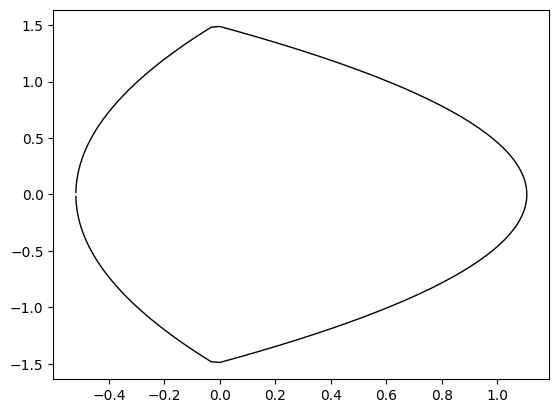

In [8]:
# Crear billar
billiard = ConfocalParabolicBilliard(xi0=1.0, eta0=1.5, num_points=200)

plt.plot(billiard.boundary[:,0], billiard.boundary[:,1], 'k-', lw=1)

### Crear grafica de densidad de probabilidad y fase del billar(3,2) caso base

In [22]:
def graficar(xi0, eta0, k_2, gamma=np.inf, angle=0.0, num_points=200):
    # Crear billar
    billiard = ConfocalParabolicBilliard(xi0, eta0, num_points)
    
    # Crear solver BWM
    bwm = BoundaryWallMethod(billiard.boundary, gamma=gamma, k=np.sqrt(k_2), angle=angle)
    
    # Crear grilla de observación
    x = np.linspace(-8, 8, 200)
    y = np.linspace(-8, 8, 200)
    X, Y = np.meshgrid(x, y)
    observation_points = np.column_stack([X.ravel(), Y.ravel()])
    
    # Calcular la onda dispersada (puede tardar varios minutos para N=200)
    psi = bwm.compute_scattered_wave(observation_points)
    Psi = psi.reshape(X.shape)

    # Calcular la densidad de probabilidad
    prob_density = np.abs(Psi)**2

    # Normalizar la densidad de probabilidad (0 a 1)
    prob_density_normalized = prob_density / np.max(prob_density)
    
    # Visualización
    plt.figure(figsize=(11, 5))
    plt.suptitle(f'Billar({xi0},{eta0}) | $k^2$={k_2}')
    
    # Densidad de probabilidad
    plt.subplot(1, 2, 1)
    plt.pcolormesh(X, Y, prob_density_normalized, shading='auto', cmap='inferno')
    plt.colorbar(label='|ψ|²')
    plt.plot(billiard.boundary[:,0], billiard.boundary[:,1], 'w-', lw=1)
    plt.title('Densidad de probabilidad')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    
    # Fase
    plt.subplot(1, 2, 2)
    plt.pcolormesh(X, Y, np.angle(Psi), shading='auto', cmap='hsv')
    cbar = plt.colorbar(label='Fase de ψ', ticks=[-np.pi, 0, np.pi])
    cbar.ax.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$'])  
    plt.plot(billiard.boundary[:,0], billiard.boundary[:,1], 'k-', lw=1)
    plt.title('Distribución de fase')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

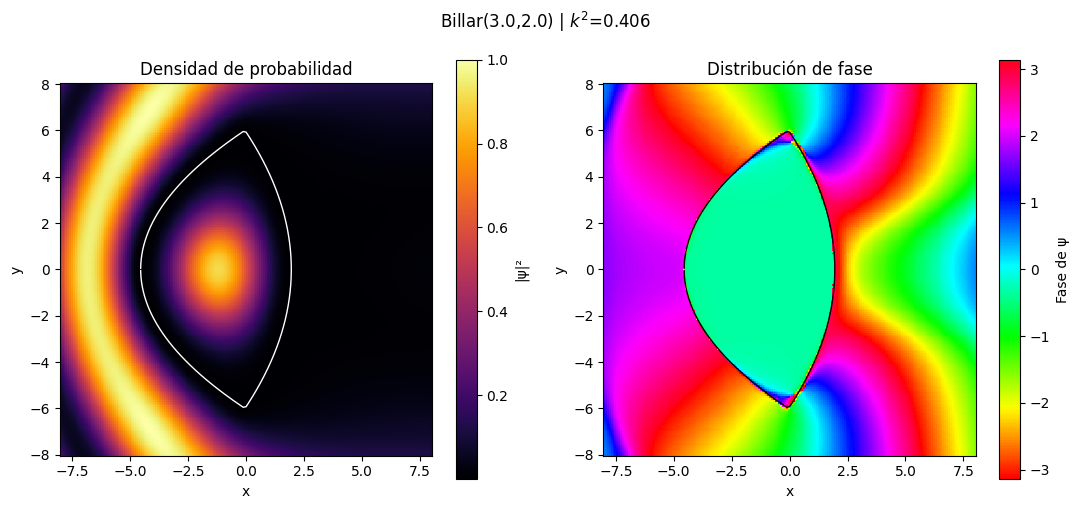

In [21]:
graficar(xi0=3.0, eta0=2.0, k_2=0.406)

ejecución completamente secuencial se demoró 313 segundos

### Espectro de |T| en función de k^2 billar(4,2)

In [44]:
# Crear instancia del billar (ejemplo con parámetros del artículo)
billiard = ConfocalParabolicBilliard(xi0=4.0, eta0=2.0, num_points=200)
bwm = BoundaryWallMethod(billiard.boundary, gamma=np.inf, k=1.0, angle=0.0)

# Escanear espectro en el rango de interés (valores de la Tabla I)
spectrum_data = bwm.scan_spectrum(k_min=0.1, k_max=2.0)

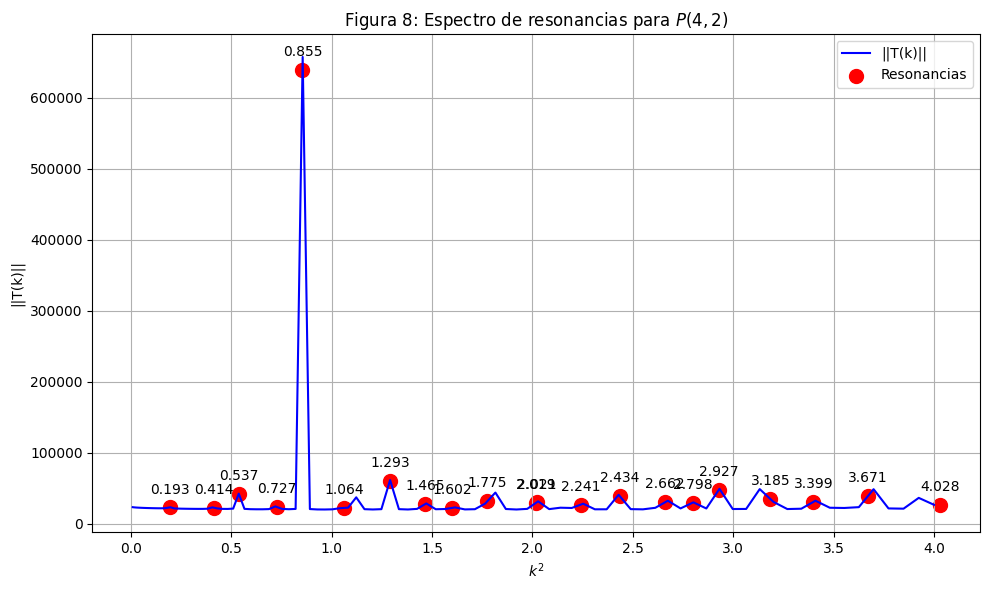

In [46]:
# Graficar
plt.figure(figsize=(10, 6))
plt.plot(spectrum_data['k_values']**2, spectrum_data['norm_values'], '-b', label='||T(k)||')
plt.scatter(spectrum_data['resonances']**2,
           np.interp(spectrum_data['resonances'], 
                    spectrum_data['k_values'],
                    spectrum_data['norm_values']),
           c='red', s=100, label='Resonancias')

# Añadir anotaciones con valores de k² (opcional)
for i, k_sq in enumerate(spectrum_data['resonances']**2):
    plt.annotate(f'{k_sq:.3f}', 
                (k_sq, np.interp(spectrum_data['resonances'][i], 
                        spectrum_data['k_values'],
                        spectrum_data['norm_values'])),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.xlabel('$k^2$')
plt.ylabel('||T(k)||')
plt.title('Figura 8: Espectro de resonancias para $P(4,2)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Espectro de |T| en función de k^2 billar(3,2)

In [27]:
# Crear instancia del billar (ejemplo con parámetros del artículo)
billiard = ConfocalParabolicBilliard(xi0=3.0, eta0=2.0, num_points=200)
bwm = BoundaryWallMethod(billiard.boundary, gamma=np.inf, k=1.0, angle=0.0)

# Escanear espectro en el rango de interés (valores de la Tabla I)
spectrum_data = bwm.scan_spectrum(k_min=0.1, k_max=2.0)

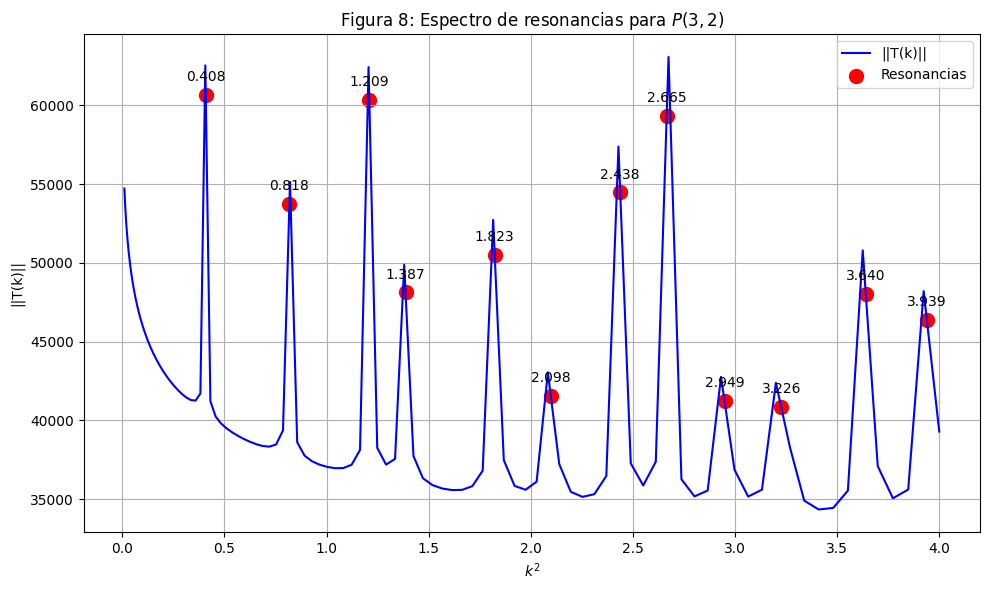

In [28]:
# Graficar
plt.figure(figsize=(10, 6))
plt.plot(spectrum_data['k_values']**2, spectrum_data['norm_values'], '-b', label='||T(k)||')
plt.scatter(spectrum_data['resonances']**2,
           np.interp(spectrum_data['resonances'], 
                    spectrum_data['k_values'],
                    spectrum_data['norm_values']),
           c='red', s=100, label='Resonancias')

# Añadir anotaciones con valores de k² (opcional)
for i, k_sq in enumerate(spectrum_data['resonances']**2):
    plt.annotate(f'{k_sq:.3f}', 
                (k_sq, np.interp(spectrum_data['resonances'][i], 
                        spectrum_data['k_values'],
                        spectrum_data['norm_values'])),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.xlabel('$k^2$')
plt.ylabel('||T(k)||')
plt.title('Figura 8: Espectro de resonancias para $P(3,2)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Espectro de |T| en función de k^2 billar(2,2) 

In [171]:
# Crear instancia del billar (ejemplo con parámetros del artículo)
billiard = ConfocalParabolicBilliard(xi0=2.0, eta0=2.0, num_points=200)
bwm = BoundaryWallMethod(billiard.boundary, gamma=np.inf, k=1.0, angle=0.0)

# Escanear espectro en el rango de interés (valores de la Tabla I)
spectrum_data = bwm.scan_spectrum(k_min=0.1, k_max=2.0)

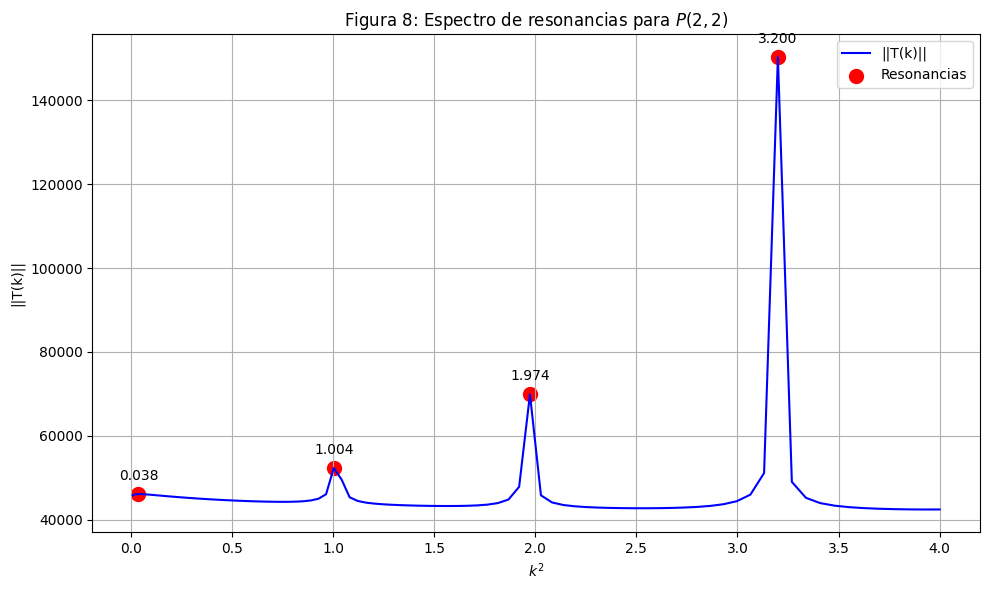

In [172]:
# Graficar
plt.figure(figsize=(10, 6))
plt.plot(spectrum_data['k_values']**2, spectrum_data['norm_values'], '-b', label='||T(k)||')
plt.scatter(spectrum_data['resonances']**2,
           np.interp(spectrum_data['resonances'], 
                    spectrum_data['k_values'],
                    spectrum_data['norm_values']),
           c='red', s=100, label='Resonancias')

# Añadir anotaciones con valores de k² (opcional)
for i, k_sq in enumerate(spectrum_data['resonances']**2):
    plt.annotate(f'{k_sq:.3f}', 
                (k_sq, np.interp(spectrum_data['resonances'][i], 
                        spectrum_data['k_values'],
                        spectrum_data['norm_values'])),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

plt.xlabel('$k^2$')
plt.ylabel('||T(k)||')
plt.title('Figura 8: Espectro de resonancias para $P(2,2)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Graficas de modos resonantes de Billar(3,2)

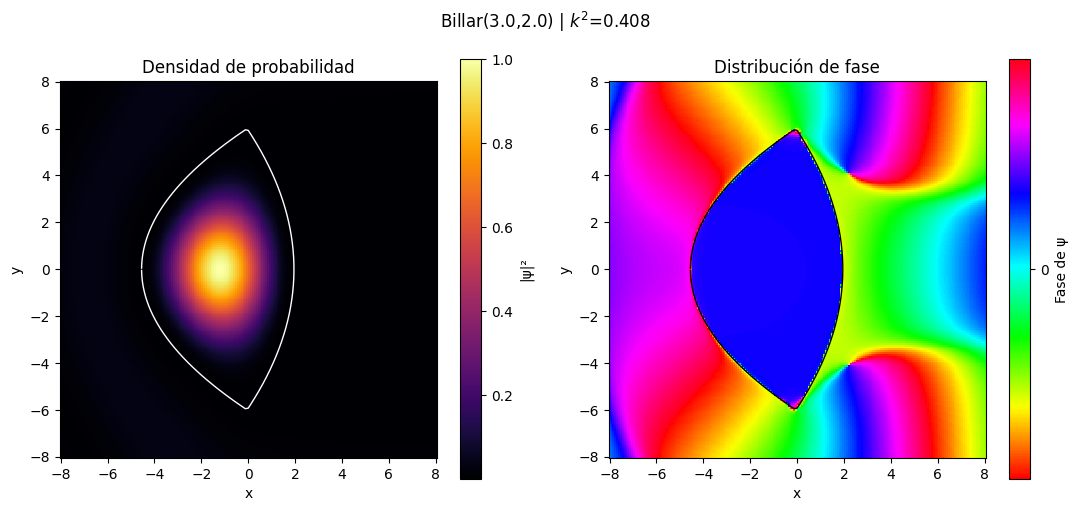

In [29]:
graficar(xi0=3.0, eta0=2.0, k_2=0.408) 

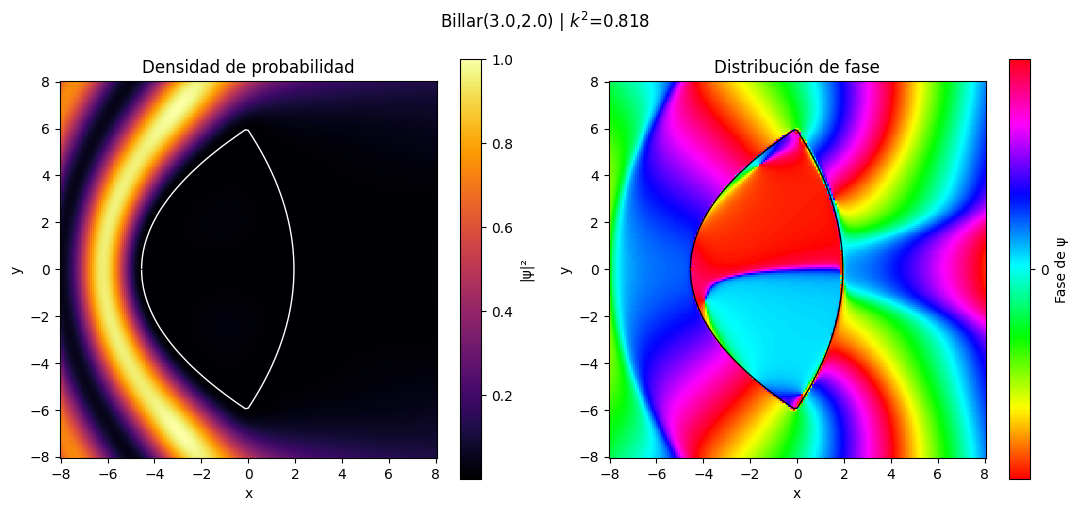

In [30]:
graficar(xi0=3.0, eta0=2.0, k_2=0.818)

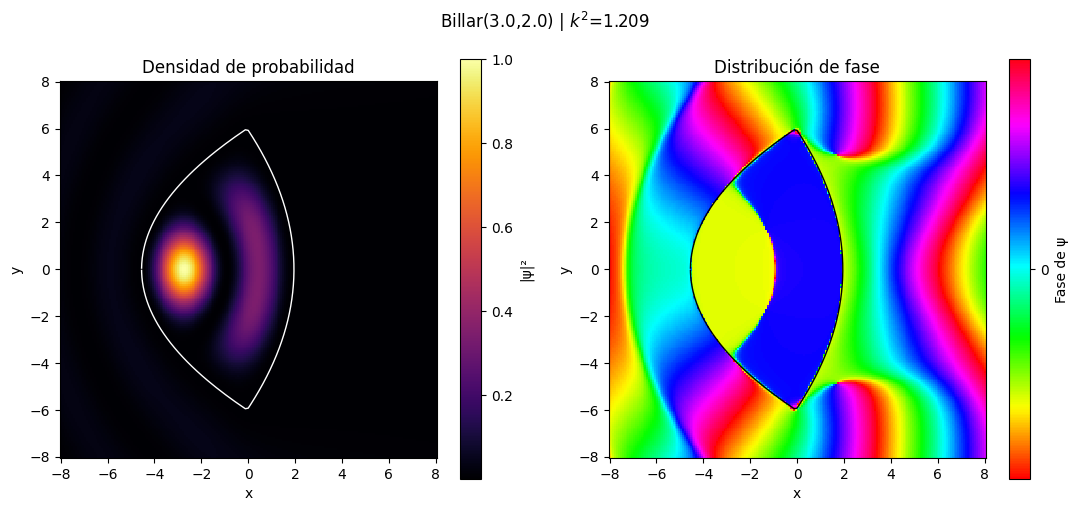

In [31]:
graficar(xi0=3.0, eta0=2.0, k_2=1.209) 

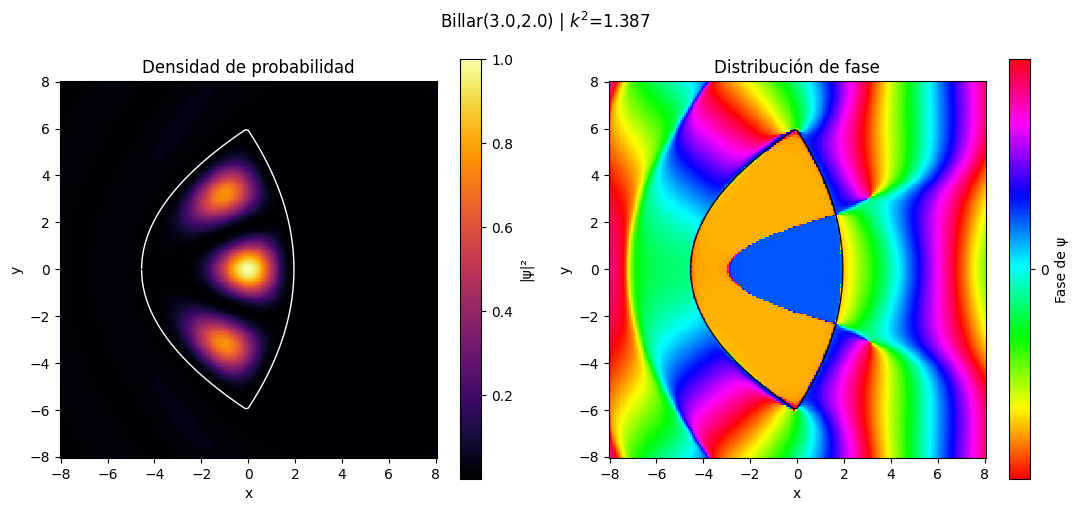

In [32]:
graficar(xi0=3.0, eta0=2.0, k_2=1.387) 

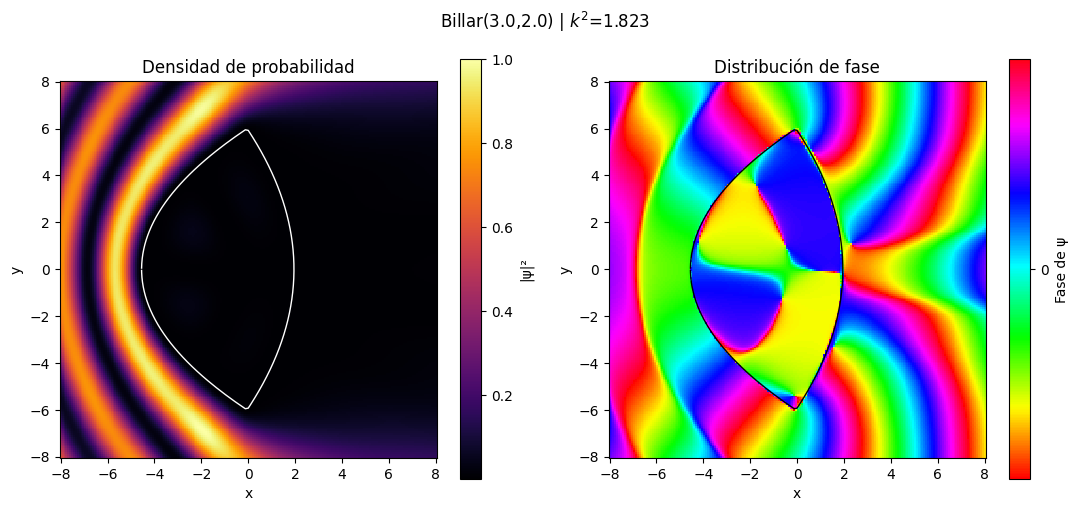

In [33]:
graficar(xi0=3.0, eta0=2.0, k_2=1.823) 

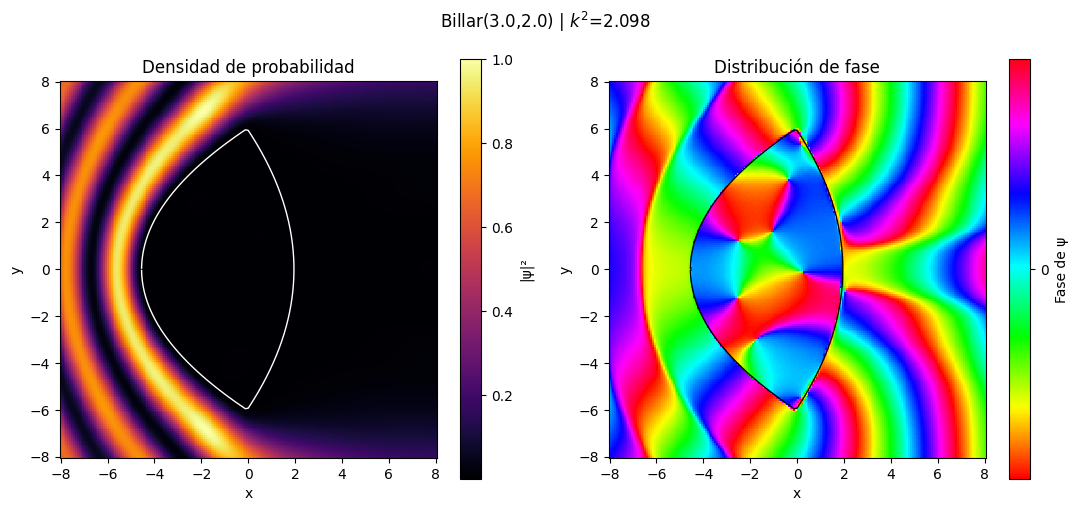

In [34]:
graficar(xi0=3.0, eta0=2.0, k_2=2.098) 

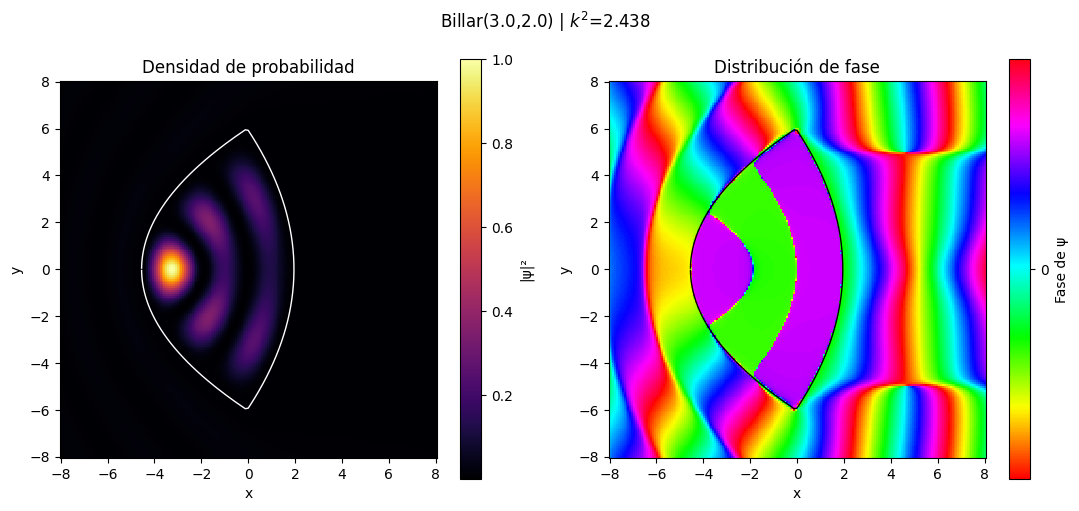

In [35]:
graficar(xi0=3.0, eta0=2.0, k_2=2.438) 

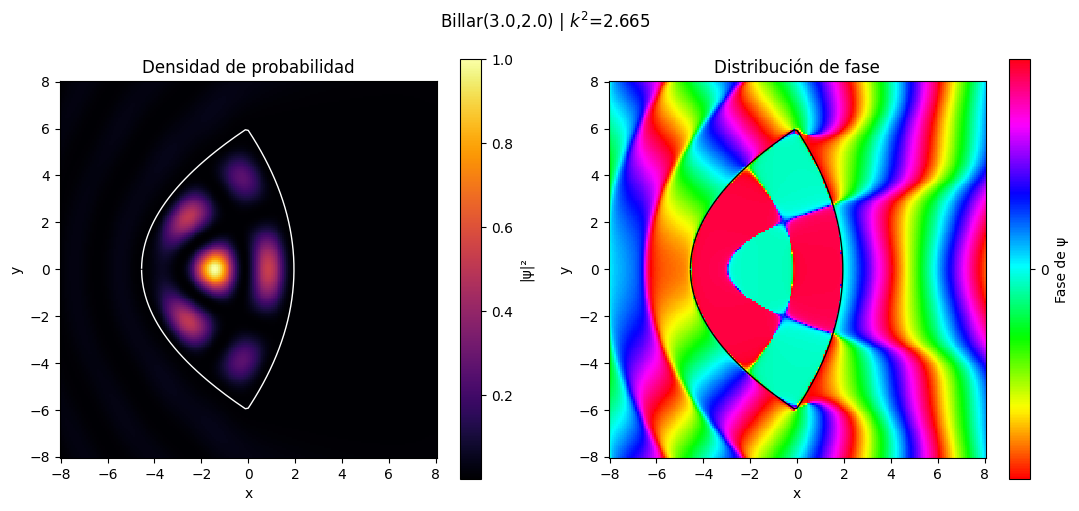

In [36]:
graficar(xi0=3.0, eta0=2.0, k_2=2.665) 

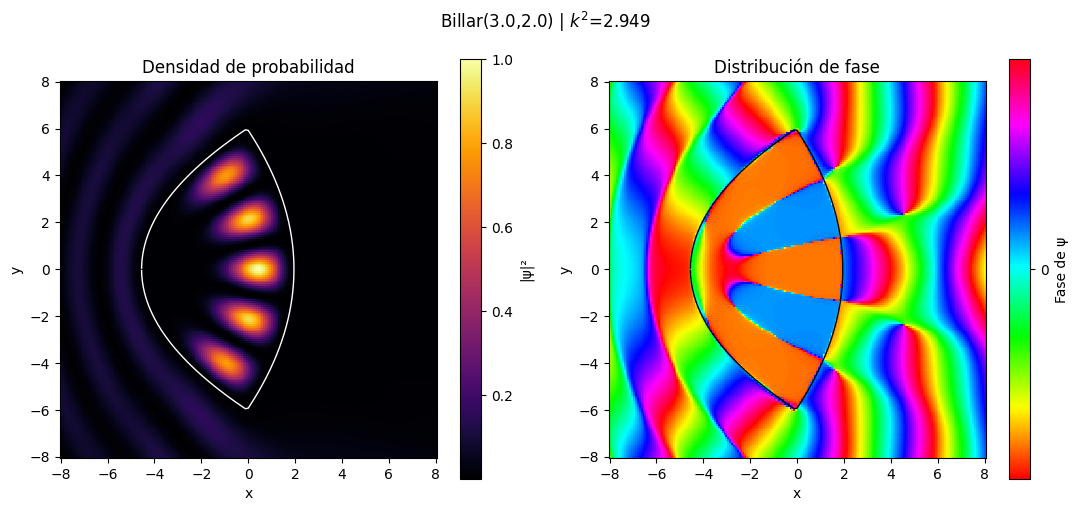

In [37]:
graficar(xi0=3.0, eta0=2.0, k_2=2.949) 

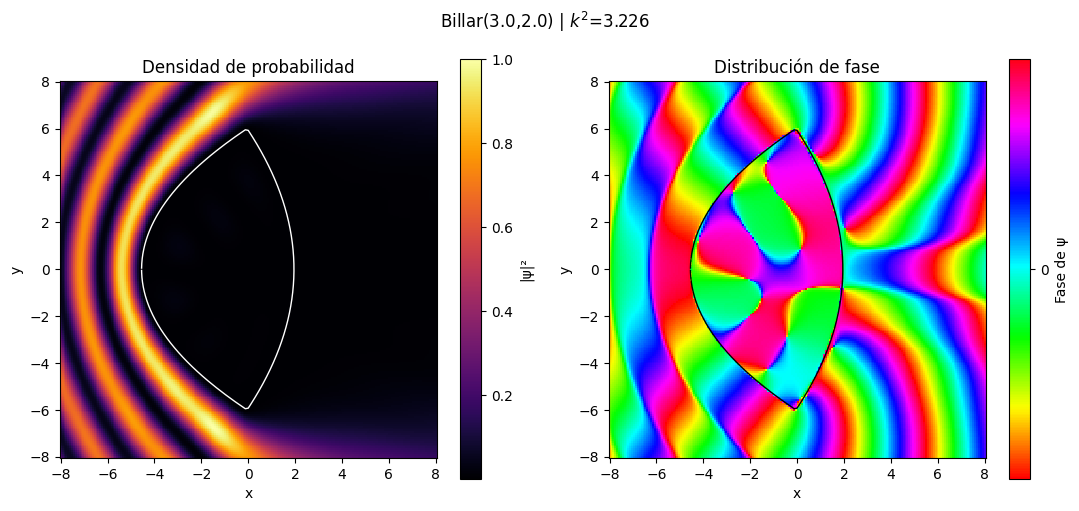

In [38]:
graficar(xi0=3.0, eta0=2.0, k_2=3.226) 

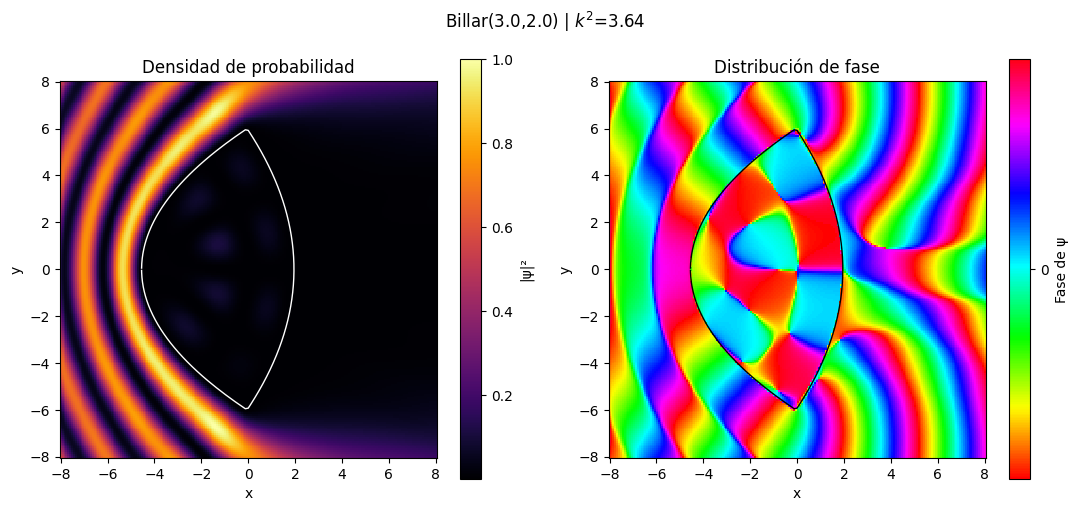

In [39]:
graficar(xi0=3.0, eta0=2.0, k_2=3.640) 

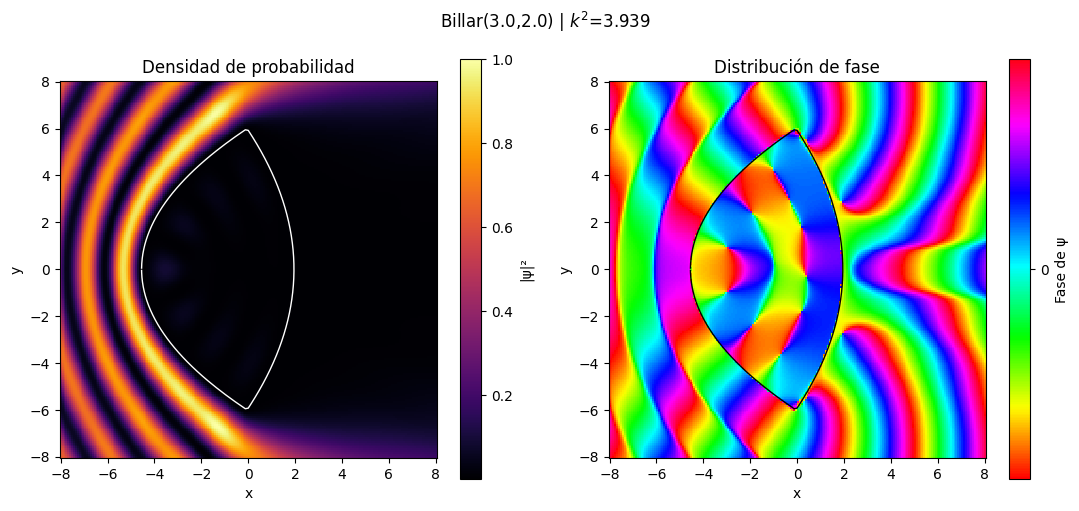

In [40]:
graficar(xi0=3.0, eta0=2.0, k_2=3.939) 

### Graficas de modos resonantes de Billar(2,2)

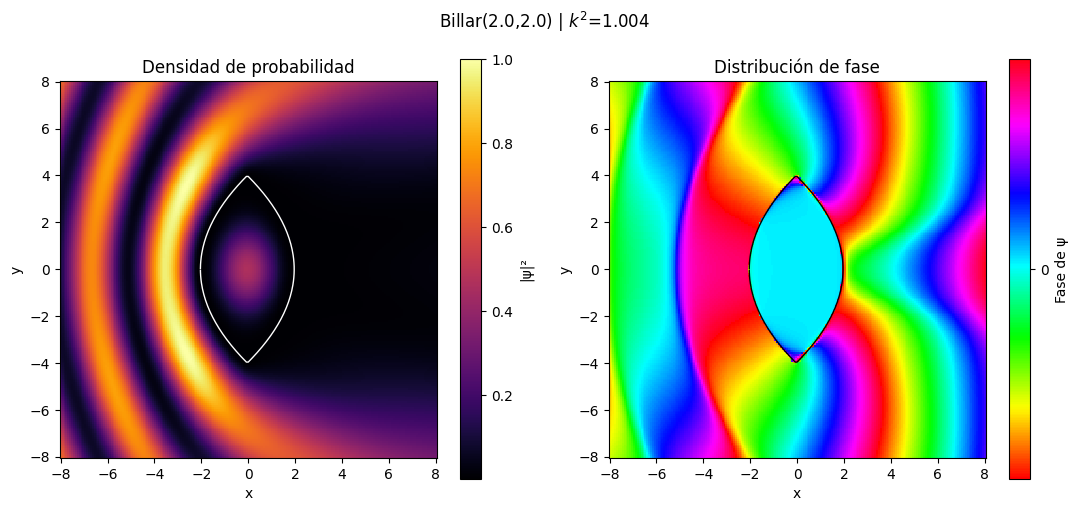

In [41]:
graficar(xi0=2.0, eta0=2.0, k_2=1.004)

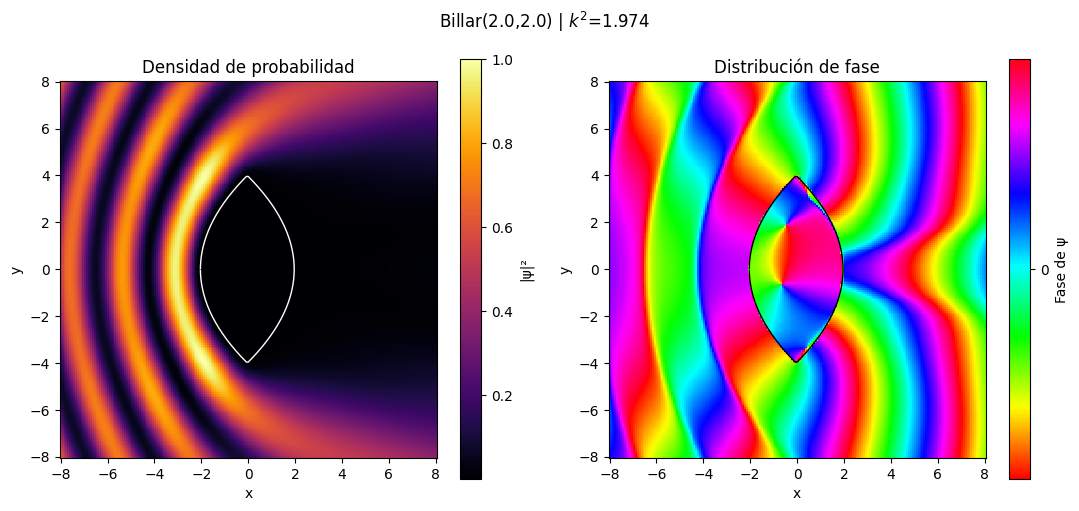

In [42]:
graficar(xi0=2.0, eta0=2.0, k_2=1.974)

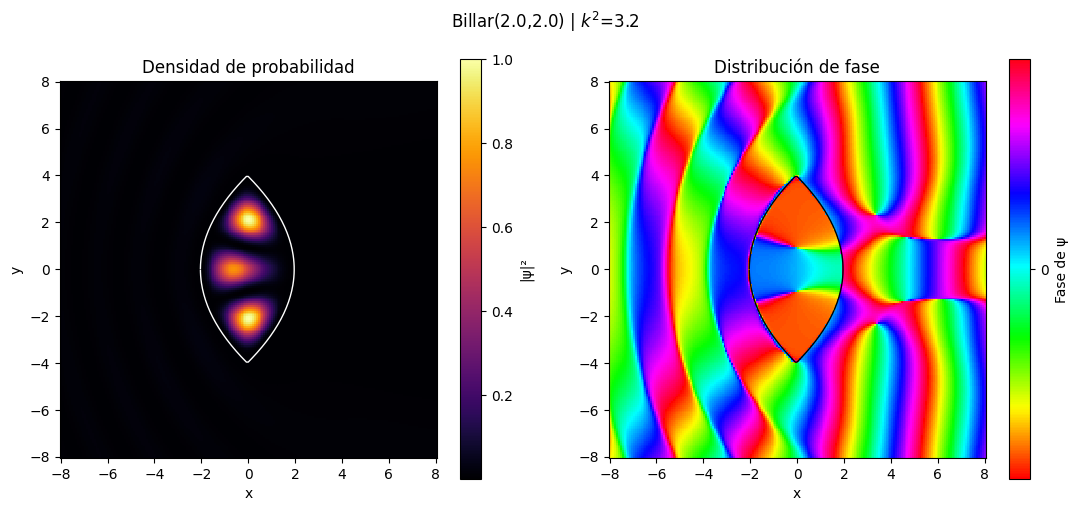

In [43]:
graficar(xi0=2.0, eta0=2.0, k_2=3.200)

### Primer de modo resonante de Billar(4,2)

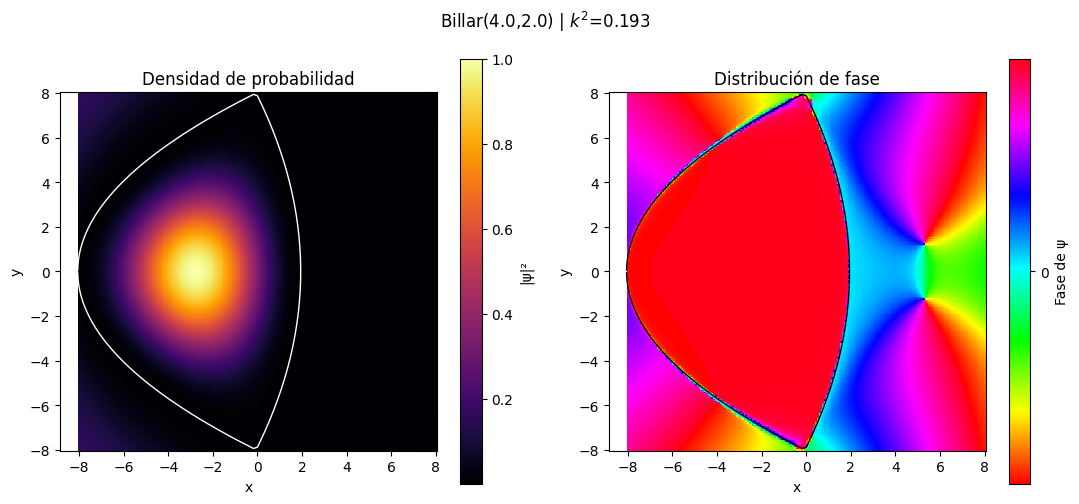

In [48]:
graficar(xi0=4.0, eta0=2.0, k_2=0.193)